# Using Existing Constrainted Optimizers

Let's examine the Barnes problem.  It's a simple 2D problem (so that we can visualize) with 3 nonlinear constraints. Additionally, we will provide analytic gradients.  We could easily compute the gradients with automatic differentiation, but they are simple enough to compute manually.

We will optimize this problem using three different tools:
- **Scipy minimize**: a wrapper to a couple different optimizers.  Convenient, but not very good solvers.  I never use these.
- **Matlab's fmincon**: I recently created a wrapper that allows you to use Matlab's fmincon (if you also have Matlab).  fmincon has four different solvers.
- **pyoptsparse**: This is a wrapper to a dozen different solvers.  One of these, SNOPT, is my most frequently used optimizer.  This one is more work to setup, but is more versatile.

In [2]:
from math import exp
import numpy as np


def barnes(x):

    a1 = 75.196
    a3 = 0.12694
    a5 = 1.0345e-5
    a7 = 0.030234
    a9 = 3.5256e-5
    a11 = 0.25645
    a13 = 1.3514e-5
    a15 = -5.2375e-6
    a17 = 7.0e-10
    a19 = -1.6638e-6
    a21 = 0.0005
    a2 = -3.8112
    a4 = -2.0567e-3
    a6 = -6.8306
    a8 = -1.28134e-3
    a10 = -2.266e-7
    a12 = -3.4604e-3
    a14 = -28.106
    a16 = -6.3e-8
    a18 = 3.4054e-4
    a20 = -2.8673

    x1 = x[0]
    x2 = x[1]
    y1 = x1*x2
    y2 = y1*x1
    y3 = x2**2
    y4 = x1**2

    # --- function value ---
    
    f = a1 + a2*x1 + a3*y4 + a4*y4*x1 + a5*y4**2 + \
        a6*x2 + a7*y1 + a8*x1*y1 + a9*y1*y4 + a10*y2*y4 + \
        a11*y3 + a12*x2*y3 + a13*y3**2 + a14/(x2+1) + \
        a15*y3*y4 + a16*y1*y4*x2 + a17*y1*y3*y4 + a18*x1*y3 + \
        a19*y1*y3 + a20*exp(a21*y1)

    # --- constraints ---

    c = np.zeros(3)
    c[0] = 1 - y1/700.0
    c[1] = y4/25.0**2 - x2/5.0
    c[2] = (x1/500.0- 0.11) - (x2/50.0-1)**2
    
    
    # --- derivatives of f ---
    
    dy1 = x2
    dy2 = y1 + x1*dy1
    dy4 = 2*x1
    dfdx1 = a2 + a3*dy4 + a4*y4 + a4*x1*dy4 + a5*2*y4*dy4 + \
        a7*dy1 + a8*y1 + a8*x1*dy1 + a9*y1*dy4 + a9*y4*dy1 + a10*y2*dy4 + a10*y4*dy2 + \
        a15*y3*dy4 + a16*x2*y1*dy4 + a16*x2*y4*dy1 + a17*y3*y1*dy4 + a17*y3*y4*dy1 + a18*y3 + \
        a19*y3*dy1 + a20*exp(a21*y1)*a21*dy1

    dy1 = x1
    dy2 = x1*dy1
    dy3 = 2*x2
    dfdx2 = a6 + a7*dy1 + a8*x1*dy1 + a9*y4*dy1 + a10*y4*dy2 + \
        a11*dy3 + a12*x2*dy3 + a12*y3 + a13*2*y3*dy3 + a14*-1/(x2+1)**2 + \
        a15*y4*dy3 + a16*y4*y1 + a16*y4*x2*dy1 + a17*y4*y1*dy3 + a17*y4*y3*dy1 + a18*x1*dy3 + \
        a19*y3*dy1 + a19*y1*dy3 + a20*exp(a21*y1)*a21*dy1

    dfdx = np.array([dfdx1, dfdx2])
    

    # --- derivatives of c ---
    
    dcdx = np.zeros((3, 2))
    dcdx[0, 0] = -x2/700.0
    dcdx[0, 1] = -x1/700.0
    dcdx[1, 0] = 2*x1/25**2
    dcdx[1, 1] = -1.0/5
    dcdx[2, 0] = 1.0/500
    dcdx[2, 1] = -2*(x2/50.0-1)/50.0

    return f, c, dfdx, dcdx

Let's create a contour plot, show the constraints, and plot the optimal solution (denoted with a star).  The feasible region is the area above the star.

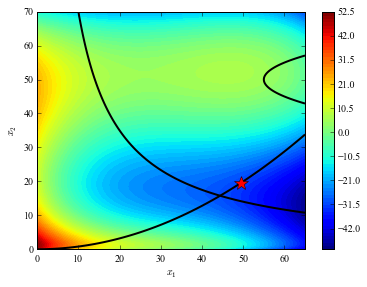

In [2]:
% matplotlib inline

n = 200
x1 = np.linspace(0, 65, n)
x2 = np.linspace(0, 70, n)

[X1, X2] = np.meshgrid(x1, x2, indexing='ij')
F = np.zeros((n, n))
C1 = np.zeros((n, n))
C2 = np.zeros((n, n))
C3 = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        f, c, _, _ = barnes([X1[i, j], X2[i, j]])
        F[i, j] = f
        C1[i, j] = c[0]
        C2[i, j] = c[1]
        C3[i, j] = c[2]

import matplotlib.pyplot as plt
plt.contourf(X1, X2, F, 100)
plt.colorbar()
plt.contour(X1, X2, C1, levels=[0], linewidths=2, colors='k')
plt.contour(X1, X2, C2, levels=[0], linewidths=2, colors='k')
plt.contour(X1, X2, C3, levels=[0], linewidths=2, colors='k')
plt.plot(49.526, 19.622, 'r*', markersize=14.0)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Scipy

First, we will use the built-in optimizers available in Scipy.  To be honest, none of these are particularly good optimizers and so I don't use them, but they are already in Scipy so there are easy to use.  They should work fine for the purposes of our homework problems.  Like Matlab's optimizer, Scipy's wants you to provide objectives and constraints separately. Additionally, for some reason, it wants you to provide the constraint gradients separately.  We are going to use some shared global variables to accomplish that.  This isn't the most ideal approach, but it's the simplest without having to introduce object oriented programming.

In [3]:
from scipy.optimize import minimize

# -------- starting point and bounds --------------
x0 = [10, 10]
ub = [65, 70]
lb = [0, 0]
# -------------------------------------------------

# convert bounds to list of tuples in format scipy wants
bounds = []
for i in range(len(lb)):
    bounds.append((lb[i], ub[i]))

# ----- common variables ----------
# these are variables we are going to save to be reused.
xlast = [-1]
csave = []
dcsave = []
# -------------------------

def obj(x):

    f, c, df, dc = barnes(x)

    # save the x we evaluated at so we don't call barnes again in con at same x.
    global xlast, csave, dcsave
    xlast = x
    csave = c
    dcsave = dc

    return f/30.0, df/30.0  # scaling so that objective is of order(1)


def con(x):
    global xlast, csave, dcsave
    
    if not np.all(xlast == x):  # check if we've already evaluated at this point, if not then reevaluate
        f, csave, df, dcsave = barnes(x)
        xlast = x

    return csave


def congrad(x):
    global xlast, csave, dcsave
    
    if not np.all(xlast == x):  # check if we've already evaluated at this point, if not then reevaluate
        f, csave, df, dcsave = barnes(x)
        xlast = x
        
    return dcsave
    

# jac=True means we are providing gradients of f
# tol is our convergence tolerances
# constraint type 'ineq' means inequality.  
# The jac for constraints is the function that returns the constraint gradients
# other options display iterations, and the maximum number of iterations
res = minimize(obj, x0, method='SLSQP', jac=True, bounds=bounds, tol=1e-7,
    constraints={'type': 'ineq', 'fun': con, 'jac': congrad}, 
    options={'disp': True, 'iprint': 2, 'maxiter': 1000})
print res.message  # print result information
print res.x  # resulting x value
print res.fun  # resulting function value
# see documentation for other outputs

  NIT    FC           OBJFUN            GNORM
    1     1    -4.643412E-02     9.293328E-02
    2     2    -1.311850E+00     3.458173E-02
    3     3    -1.046811E+00     1.946381E-02
    4     4    -1.032584E+00     1.869941E-02
    5     5    -1.032511E+00     1.869569E-02
    7     6    -1.032511E+00     1.869569E-02
    8     7    -1.032511E+00     1.869569E-02
    9    18    -1.032511E+00     1.869569E-02
   10    29    -1.032511E+00     1.869569E-02
   12    40    -1.032511E+00     1.869569E-02
   14    51    -1.032511E+00     1.869569E-02
   16    62    -1.032511E+00     1.869569E-02
   17    73    -1.032511E+00     1.869569E-02
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.03251089717
            Iterations: 17
            Function evaluations: 73
            Gradient evaluations: 13
Optimization terminated successfully.
[ 46.1256296   17.02058965]
-1.03251089717


SLSQP does ok, but doesn't converge as well as it should.  

## fmincon

Matlab's fmincon is a good optimizer.  I recently created a wrapper that allows us to call it from Python (if you also have Matlab and its optimization toolbox).  You first need to download the files opt.py and optimize.m from [here](https://github.com/BYUFLOWLab/pyfmincon).  You can then use fmincon just like in the Matlab example, but run entirely from Python, complete with callbacks to Python functions.

First, I will create a short wrapper function so that I can perform scaling or any other transformations that I want to.

In [1]:
def barneswrap(x):

    f, c, dfdx, dcdx = barnes(x)

    return f/30.0, c, dfdx/30.0, np.transpose(dcdx)  # transpose b.c. of matlab definition

In [4]:
from opt import fmincon

# --- name of function to optimize ----
function = 'barnes.barneswrap'  # in this case I needed to put the barneswrap function in a file called barnes.py because I can't call back into this notebook.
providegradients = True

# -------- starting point and bounds --------------
x0 = np.array([10.0, 10.0])
ub = np.array([65.0, 70.0])
lb = np.array([0.0, 0.0])


# ---- set options ----
options = {'Algorithm': 'active-set', 'AlwaysHonorConstraints': 'bounds',
    'display': 'iter-detailed', 'MaxIter': 1000, 'MaxFunEvals': 10000,
    'TolCon': 1e-6, 'TolFun': 1e-6, 'Diagnostics': 'on'}

# --- load fmincon and run ----
xopt, fopt, exitflag, output = fmincon(x0, ub, lb, function, options,
    providegradients=providegradients)

--- starting matlab engine ---
--- calling fmincon ---


(rest of output to terminal pasted below):

```
____________________________________________________________
   Diagnostic Information

Number of variables: 2

Functions 
Objective and gradient:               optimize/obj
Hessian:                              finite-differencing (or Quasi-Newton)
Nonlinear constraints and gradient:   optimize/con

Constraints
Number of nonlinear inequality constraints: 3
Number of nonlinear equality constraints:   0
 
Number of linear inequality constraints:    0
Number of linear equality constraints:      0
Number of lower bound constraints:          2
Number of upper bound constraints:          2

Algorithm selected
   active-set


____________________________________________________________
   End diagnostic information

                                Max     Line search  Directional  First-order 
 Iter F-count        f(x)   constraint   steplength   derivative   optimality Procedure 
    0      1   -0.0464341       0.8571                                         Infeasible start point
    1      3    -0.593993      -0.1654            1       -0.084      3.3e+03   
    2      5    -0.607653      -0.1727            1      -0.0185       0.0535  Hessian modified twice  
    3      7    -0.839436      -0.1437            1      -0.0187       0.0321  Hessian modified  
    4      9     -0.85503    -0.004513            1     -0.00814       0.0115   
    5     11     -0.85577   -4.479e-06            1     -0.00938       0.0141   
    6     13    -0.870254    0.0006384            1      -0.0148        0.011  Hessian modified  
    7     15     -1.03914       0.2137            1      -0.0118       0.0127  Hessian modified  
    8     17     -1.02281     0.001222            1       0.0171       0.0152  Hessian modified  
    9     19      -1.0386     0.002213            1      -0.0126      0.00855  Hessian modified  
   10     21     -1.05581      0.01156            1      -0.0089      0.00156   
   11     23     -1.05457    5.584e-05            1      0.00404     0.000214   
   12     25     -1.05456    1.269e-06            1     0.000101     6.98e-06  Hessian modified  
   13     27     -1.05456    1.087e-09            1     0.000144     2.11e-09  Hessian modified  

Optimization completed: The first-order optimality measure, 2.107406e-09, is less
than options.TolFun = 1.000000e-06, and the maximum constraint violation, 1.086800e-09,
is less than options.TolCon = 1.000000e-06.

Optimization Metric                                                 Options
first-order optimality =   2.11e-09                        TolFun =   1e-06 (selected)
max(constraint violation) =   1.09e-09                     TolCon =   1e-06 (selected)

Active inequalities (to within options.TolCon = 1e-06):
  lower      upper     ineqlin   ineqnonlin
                                     2
```

In [6]:
print xopt
print fopt

[49.5262866794,19.6228245726]
-1.05456034736


This finds a better solution, than does scipy.  It actually converges to the minimum.

## pyoptsparse

The optimization framework I generally use is [pyoptsparse](https://bitbucket.org/mdolab/pyoptsparse) (which is a successor to pyopt).  This is an interface to a dozen or so different optimizers.  Among those the one I use most frequently is SNOPT.  This is a commercial code, but if you are a student in our department come talk to me and I can get you a copy through our department license.  SNOPT is an advanced optimizer with many options.

pyoptsparse is not documented super well at this time.  There is some documentation available, but you need to build it through sphinx.  Most of what you'd find is shown in the below example.

In [3]:
import pyoptsparse

def func(xdict):  # return both f and c

    x = xdict['x']  # uses a dictionary with whatever keys you define below
    f, c, df, dc = barnes(x)
    
    # you must reutrn your outputs in a dictionary format as well
    # again keys are customizable but must match below
    outputs = {}
    outputs['obj'] = f / 30.0  # scaling 
    outputs['con'] = c
    
    # these gradients aren't directly used in this function but we will save them for later
    outputs['g-obj'] = df / 30.0
    outputs['g-con'] = dc
    outputs['g-x'] = x
    
    fail = False  # can use a flag to denote a failure, optimizer will try to recover and progress
    
    return outputs, fail


def grad(xdict, fdict):
    
    # check if this was the x-location we just evaluated from func
    if not np.array_equal(xdict['x'], fdict['g-x']):
        f, c, df, dc = barnes(x)
    else:
        df = fdict['g-obj']
        dc = fdict['g-con']
    
    # this dictionary format allows you to supply partial derivatives separately.
    gout = {}
    gout['obj'] = {}
    gout['obj']['x'] = df
    gout['con'] = {}
    gout['con']['x'] = dc

    fail = False

    return gout, fail


# -------- starting point and bounds --------------
x0 = [10, 10]
ub = [65, 70]
lb = [0, 0]
# -------------------------------------------------

# define the problem.  Use same keys as above.
optProb = pyoptsparse.Optimization('barnes', func)
optProb.addObj('obj')
optProb.addVarGroup('x', len(x0), type='c', lower=lb, upper=ub, value=x0)
optProb.addConGroup('con', 3, lower=-float("inf"), upper=0.0)  # notice we can use a 2-sided constraint

# choose the solver, in this case SNOPT
opt = pyoptsparse.SNOPT()
# set options.  There are about 100 different options.  See SNOPT manual for full list
opt.setOption('Major feasibility tolerance', 1e-6)
opt.setOption('Major optimality tolerance', 1e-6)
opt.setOption('iPrint', 6)  # normally you would not want to do this, but this notebook can't write files.  In general, you'll get two output files with detailed information.
opt.setOption('iSumm', 6)
sol = opt(optProb, sens=grad)  # define where we are getting gradients from.  Other options include FD and CS


(rest of terminal output pasted below)

```
  ==============================
         S N O P T  7.2-12.3 (Aug 2014)
         ==============================

 ==============================
 S N O P T  7.2-12.3 (Aug 2014)
 ==============================
      Major feasibility tolerance  1.00000000E-06
      Major optimality tolerance  1.00000000E-06
      Derivative level               3
1
 
 
 SNMEMB EXIT 100 -- finished successfully
 SNMEMB EXIT 100 -- finished successfully
 SNMEMB INFO 104 -- memory requirements estimated
 SNMEMB INFO 104 -- memory requirements estimated

         ==============================
         S N O P T  7.2-12.3 (Aug 2014)
         ==============================

 ==============================
 S N O P T  7.2-12.3 (Aug 2014)
 ==============================
      Major feasibility tolerance  1.00000000E-06
      Major optimality tolerance  1.00000000E-06
      Derivative level               3
1
 
 
 Parameters
 ==========

 Files
 -----
 Solution file..........         0       Old basis file ........         0       Standard input.........         5
 Insert file............         0       New basis file ........         0       (Printer)..............         6
 Punch file.............         0       Backup basis file......         0       (Specs file)...........         0
 Load file..............         0       Dump file..............         0       Standard output........         6

 Frequencies
 -----------
 Print frequency........       100       Check frequency........        60       Save new basis map.....       100
 Summary frequency......       100       Factorization frequency        50       Expand frequency.......     10000

 QP subproblems
 --------------
 QPsolver Cholesky......
 Scale tolerance........     0.900       Minor feasibility tol..  1.00E-06       Iteration limit........     10000
 Scale option...........         0       Minor optimality  tol..  5.00E-07       Minor print level......         1
 Crash tolerance........     0.100       Pivot tolerance........  3.25E-11       Partial price..........         1
 Crash option...........         3       Elastic weight.........  1.00E+04       Prtl price section ( A)         2
                                         New superbasics........        99       Prtl price section (-I)         3

 The SQP Method
 --------------
 Minimize...............                 Cold start.............                 Proximal Point method..         1
 Nonlinear objectiv vars         2       Major optimality tol...  1.00E-06       Function precision.....  3.00E-13
 Unbounded step size....  1.00E+20       Superbasics limit......         2       Difference interval....  5.48E-07
 Unbounded objective....  1.00E+15       Reduced Hessian dim....         2       Central difference int.  6.70E-05
 Major step limit.......  2.00E+00       Derivative linesearch..                 Derivative level.......         3
 Major iterations limit.      1000       Linesearch tolerance...   0.90000       Verify level...........         0
 Minor iterations limit.       500       Penalty parameter......  0.00E+00       Major Print Level......         1

 Hessian Approximation
 ---------------------
 Full-Memory Hessian....                 Hessian updates........  99999999       Hessian frequency......  99999999
                                                                                 Hessian flush..........  99999999

 Nonlinear constraints
 ---------------------
 Nonlinear constraints..         3       Major feasibility tol..  1.00E-06       Violation limit........  1.00E+06
 Nonlinear Jacobian vars         2

 Miscellaneous
 -------------
 LU factor tolerance....      3.99       LU singularity tol.....  3.25E-11       Timing level...........         3
 LU update tolerance....      3.99       LU swap tolerance......  1.22E-04       Debug level............         0
 LU partial  pivoting...                 eps (machine precision)  2.22E-16       System information.....        No
                                                                                 Sticky parameters......        No
1
 
 

 

 Matrix statistics
 -----------------
               Total      Normal        Free       Fixed     Bounded
 Rows              3           3           0           0           0
 Columns           2           0           0           0           2

 No. of matrix elements                    6     Density     100.000
 Biggest  constant element        0.0000E+00  (excluding fixed columns,
 Smallest constant element        0.0000E+00   free rows, and RHS)

 No. of objective coefficients             0

 Nonlinear constraints       3     Linear constraints       0

 Nonlinear constraints       3     Linear constraints       0
 Nonlinear variables         2     Linear variables         0
 Nonlinear variables         2     Linear variables         0
 Jacobian  variables         2     Objective variables      2
 Jacobian  variables         2     Objective variables      2
 Total constraints           3     Total variables          2
 Total constraints           3     Total variables          2
1
 
 

 

 
 The user has defined       6   out of       6   constraint gradients.
 The user has defined       6   out of       6   constraint gradients.
 The user has defined       2   out of       2   objective  gradients.
 The user has defined       2   out of       2   objective  gradients.

 Cheap test of user-supplied problem derivatives...

 The constraint gradients seem to be OK.

 -->  The largest discrepancy was    4.14E-09  in constraint     4
 

 The objective  gradients seem to be OK.

 Gradient projected in one direction   8.49257519325E-03
 Difference approximation              8.49259367756E-03
1
 
 
 

   Itns Major Minors    Step   nCon Feasible  Optimal  MeritFunction     L+U BSwap     nS  condHz Penalty
      2     0      2              1  5.7E-02  1.7E-01 -4.6434117E-02       7                              _  r

 Major Minors     Step   nCon Feasible  Optimal  MeritFunction    nS Penalty
     0      2               1  5.7E-02  1.7E-01 -4.6434117E-02                 r
      2     1      0 2.4E-02      2  5.2E-02  1.6E-01  1.0807111E+02       7                      3.0E+02 _n rl
     1      0  2.4E-02      2  5.2E-02  1.6E-01  1.0807111E+02       3.0E+02 n rl
      2     2      0 2.6E-02      3  4.7E-02  1.5E-02  1.4673728E+02       7                      4.2E+02 _sm l
     2      0  2.6E-02      3  4.7E-02  1.5E-02  1.4673728E+02       4.2E+02 sm l
      3     3      1 9.6E-01      4 (0.0E+00) 1.4E-02 -2.6802284E+01       7            1 5.2E+04 2.1E+01 _ m l
     3      1  9.6E-01      4 (0.0E+00) 1.4E-02 -2.6802284E+01     1 2.1E+01  m l
      4     4      1 6.0E-05      7 (0.0E+00) 1.1E-01 -1.1353613E+01       7            1 6.6E+02 1.1E+02 _ M
     4      1  6.0E-05      7 (0.0E+00) 1.1E-01 -1.1353613E+01     1 1.1E+02  M
      5     5      1 2.1E-03     10 (0.0E+00) 1.5E-01 -6.5535385E+00       7            1 6.6E+02 2.9E+02 _ M
     5      1  2.1E-03     10 (0.0E+00) 1.5E-01 -6.5535385E+00     1 2.9E+02  M
      6     6      1 3.3E-01     13 (0.0E+00) 9.8E-02 -2.0542686E+00       7            1 3.5E+02 5.4E+02 _ M
     6      1  3.3E-01     13 (0.0E+00) 9.8E-02 -2.0542686E+00     1 5.4E+02  M
      7     7      1 2.8E-01     16 (0.0E+00) 6.8E-02 -1.1304024E+00       7            1 2.2E+02 8.2E+02 _ M
     7      1  2.8E-01     16 (0.0E+00) 6.8E-02 -1.1304024E+00     1 8.2E+02  M
      8     8      1 4.2E-02     20 (0.0E+00) 6.3E-02 -9.6396090E-01       7            1 2.1E+02 1.4E+03 _ M
     8      1  4.2E-02     20 (0.0E+00) 6.3E-02 -9.6396090E-01     1 1.4E+03  M
      9     9      1 1.2E-01     24 (0.0E+00) 5.4E-02 -8.5955984E-01       7            1 1.8E+02 2.1E+03 _ M
     9      1  1.2E-01     24 (0.0E+00) 5.4E-02 -8.5955984E-01     1 2.1E+03  M
     10    10      1 2.5E-01     28 (0.0E+00) 3.4E-02 -8.2681328E-01       7            1 1.3E+02 2.9E+03 _ M

 Major Minors     Step   nCon Feasible  Optimal  MeritFunction    nS Penalty
    10      1  2.5E-01     28 (0.0E+00) 3.4E-02 -8.2681328E-01     1 2.9E+03  M
     11    11      1 4.4E-01     31 (0.0E+00) 1.2E-02 -8.3337227E-01       7            1 7.4E+01 3.4E+03 _ M
    11      1  4.4E-01     31 (0.0E+00) 1.2E-02 -8.3337227E-01     1 3.4E+03  M
     13    12      2 1.0E+00     32 (6.0E-07) 3.3E-02 -8.7787542E-01       7     1      1 1.7E+00 8.6E+02 _
    12      2  1.0E+00     32 (6.0E-07) 3.3E-02 -8.7787542E-01     1 8.6E+02
     14    13      1 1.0E+00     34  7.4E-03  3.3E-03 -1.0729636E+00       7            1 2.6E+01 9.8E+01 _ m
    13      1  1.0E+00     34  7.4E-03  3.3E-03 -1.0729636E+00     1 9.8E+01  m
     15    14      1 1.0E+00     36  1.3E-04  2.9E-03 -1.0519477E+00       7            1 1.7E+00 3.3E+01 _ M
    14      1  1.0E+00     36  1.3E-04  2.9E-03 -1.0519477E+00     1 3.3E+01  M
     16    15      1 1.0E+00     37  3.9E-05  5.4E-05 -1.0545592E+00       7            1 1.8E+00 3.3E+01 _
    15      1  1.0E+00     37  3.9E-05  5.4E-05 -1.0545592E+00     1 3.3E+01
     17    16      1 1.0E+00     38 (2.2E-09) 1.8E-06 -1.0545603E+00       7            1 1.7E+00 3.3E+01 _
    16      1  1.0E+00     38 (2.2E-09) 1.8E-06 -1.0545603E+00     1 3.3E+01
     18    17      1 1.0E+00     39 (1.9E-11)(1.7E-07)-1.0545603E+00       7            1 1.9E+00 3.3E+01 _
    17      1  1.0E+00     39 (1.9E-11)(1.7E-07)-1.0545603E+00     1 3.3E+01
1
 
 
 SNOPTC EXIT   0 -- finished successfully
 SNOPTC EXIT   0 -- finished successfully
 SNOPTC INFO   1 -- optimality conditions satisfied
 SNOPTC INFO   1 -- optimality conditions satisfied

 Problem name                 barnes

 Problem name                 barnes
 No. of iterations                  18   Objective value     -1.0545603473E+00
 No. of iterations                  18   Objective value     -1.0545603473E+00
 No. of major iterations            17   Linear objective     0.0000000000E+00
 No. of major iterations            17   Linear objective     0.0000000000E+00
 Penalty parameter           3.330E+01   Nonlinear objective -1.0545603473E+00
 Penalty parameter           3.330E+01   Nonlinear objective -1.0545603473E+00
 No. of calls to funobj             40   No. of calls to funcon             40
 No. of calls to funobj             40   No. of calls to funcon             40
 No. of superbasics                  1   No. of basic nonlinears             2
 No. of superbasics                  1   No. of basic nonlinears             2
 No. of degenerate steps             0   Percentage                       0.00
 No. of degenerate steps             0   Percentage                       0.00
 Max x                       1 5.0E+01   Max pi                      2 1.2E-01
 Max x                       1 5.0E+01   Max pi                      2 1.2E-01
 Max Primal infeas           0 0.0E+00   Max Dual infeas             2 3.4E-07
 Max Primal infeas           0 0.0E+00   Max Dual infeas             2 3.4E-07
 Nonlinear constraint violn    9.4E-10
 Nonlinear constraint violn    9.4E-10
1
 
 
 Name           barnes                   Objective Value     -1.0545603473E+00

 Status         Optimal Soln             Iteration     18    Superbasics     1

 Objective       (Min)
 RHS            ??@	?
 Ranges         pN3
 Bounds         

 Section 1 - Rows

  Number  ...Row.. State  ...Activity...  Slack Activity  ..Lower Limit.  ..Upper Limit.  .Dual Activity    ..i
 
       3  r      1   SBS        -0.38835        -0.38835           None           .               .           1
       4  r      2    UL         0.00000         0.00000           None           .             -0.12169      2
       5  r      3    BS        -0.38006        -0.38006           None           .               .           3
1
 
 
 Section 2 - Columns

  Number  .Column. State  ...Activity...  .Obj Gradient.  ..Lower Limit.  ..Upper Limit.  Reduced Gradnt    m+j
 
       1  x      1    BS        49.52622        -0.01929          .             65.00000         0.00000      4
       2  x      2    BS        19.62277         0.02434          .             70.00000        -0.00000      5

 Solution printed on file   6
 
 
 Time for MPS input                             0.00 seconds
 Time for MPS input                             0.00 seconds
 Time for solving problem                       0.03 seconds
 Time for solving problem                       0.03 seconds
 Time for solution output                       0.00 seconds
 Time for solution output                       0.00 seconds
 Time for constraint functions                  0.03 seconds
 Time for constraint functions                  0.03 seconds
 Time for objective function                    0.00 seconds
 Time for objective function                    0.00 seconds
 ```

In [8]:
print sol

     Name        Type                         Bound
     

barnes

        Objective Function: func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    0.0305
       User Objective Time :       0.0015
       User Sensitivity Time :     0.0001
       Interface Time :            0.0258
       Opt Solver Time:            0.0031
    Calls to Objective Function :      40
    Calls to Sens Function :           39

    Objectives:
        Name        Value        Optimum
	    obj       -1.05456             0

   Variables (c - continuous, i - integer, d - discrete):
           Name      Type       Value       Lower Bound  Upper Bound
	    x_0       c	     49.526219       0.00e+00     6.50e+01 
	    x_1       c	     19.622771       0.00e+00     7.00e+01 

   Constraints (i - inequality, e - equality):
        Name    Type                    Bounds
	    con   	  i            -inf <= -0.388345 <= 0.00e+00
	    con   

In [11]:
print sol.xStar

OrderedDict([('x', array([ 49.52621914,  19.62277105]))])


In [13]:
print sol.fStar

-1.05456034733


SNOPT finds the same answer the fmincon does, and spits out a lot of information.